# Parameters study
The herein notebook presents an investigation about the parameters used during the 
provenance analysis solution.

For that, after an initial empirically analysis, we fixed a set of variables from 
the provenance model, and check the performance of the model which varying a specific
parameter.

During the experiment, we used the SPP extended v1 dataset.

In [1]:
%pylab inline
from glob import glob
import sys
import pandas as pd
from pathlib import Path

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read study results
document_eval = pd.read_csv('docEvaluation2023-10-09_09-03-58.csv').drop(columns=['Unnamed: 0'])
panel_eval =  pd.read_csv('panelEvaluation2023-10-09_09-11-24.csv').drop(columns=['Unnamed: 0'])

In [ ]:
document_eval.sort_values(by=['global_quality', 'grouping_quality','relationship_quality'], ascending=False)[["alignment","desc","matching","max_queuesize","min_area","min_keypoints","rank_top_k","same_class","global_quality","grouping_quality","relationship_quality"]].head(10)

In [4]:
eval = document_eval[(document_eval["alignment"] == "CV_MAGSAC") & (document_eval["desc"] == "vlfeat_sift_heq") & (document_eval["matching"] == "BF")]

In [5]:
# Print plot of panel and document eval fixing the max_queuesize, min_area and min_keypoints, but varying the rank_top_k
def plot(ax, results, x, max_queuesize=None, min_area=None, min_keypoints=None, rank_top_k=None):
    if max_queuesize is not None:
        results = results[results["max_queuesize"] == max_queuesize]
    if min_area is not None:
        results = results[results["min_area"] == min_area]
    if min_keypoints is not None:
        results = results[results["min_keypoints"] == min_keypoints]
    if rank_top_k is not None:
        results = results[results["rank_top_k"] == rank_top_k]

    # results = results.rename(columns={"global_quality": "Content Classification", "grouping_quality": "Content Grouping", "relationship_quality": "Content Pairing"})
    results = results.rename(columns={"global_precision": "Content Classification Precision", "grouping_precision": "Content Grouping Precision", "relationship_precision": "Content Pairing Precision"})
    # results = results.rename(columns={"global_recall": "Content Classification Recall", "grouping_recall": "Content Grouping Recall", "relationship_recall": "Content Pairing Recall"})
    results = results.sort_values(by=[x])
    # results.plot.scatter(x=x, y=["Content Classification"], figsize=(10,5), ax=ax)
    results.plot(x=x, y=["Content Classification Precision"], figsize=(10,5), ax=ax, linestyle='-', marker='o', markersize=4)
    results.plot(x=x, y=["Content Grouping Precision"], figsize=(10,5), ax=ax, linestyle='-', marker='x', markersize=4)
    results.plot(x=x, y=["Content Pairing Precision"], figsize=(10,5), ax=ax, linestyle='-', marker='v', markersize=4)

Text(0.5, 1.0, 'Document Evaluation')

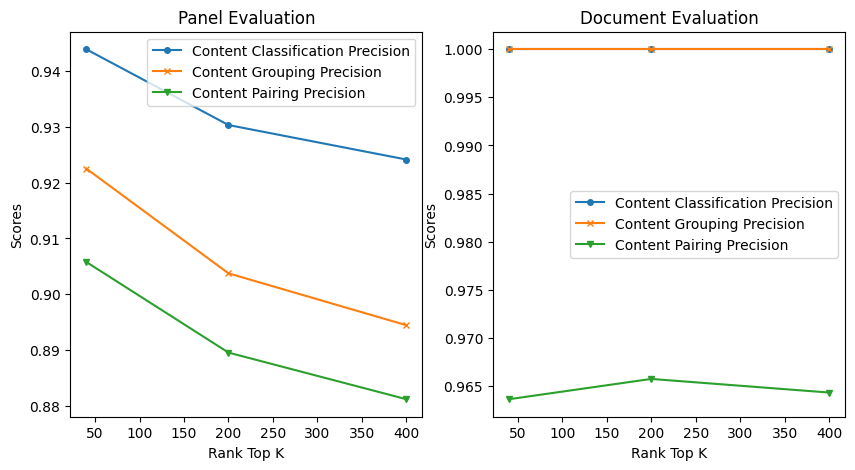

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plot(ax[0], panel_eval, x='rank_top_k', max_queuesize=300, min_area=0.01, min_keypoints=20)
ax[0].set_xlabel("Rank Top K"); ax[0].set_ylabel("Scores"); ax[0].set_title("Panel Evaluation")
plot(ax[1], document_eval,'rank_top_k', max_queuesize=300, min_area=0.01, min_keypoints=20)
ax[1].set_xlabel("Rank Top K"); ax[1].set_ylabel("Scores"); ax[1].set_title("Document Evaluation")

**TOP-K** is employed in the content retrieval phase to determine the number of the most similar images to consider during content image retrieval. A small value of "k" can decrease the likelihood of detecting reused panels, while a high "k" may introduce significant overhead to the pipeline, as the probe and lower-ranked items might have substantially different content.

We preferred to choose K=400 due to this slight increase in performance, with a small impact on the method runtime.



Text(0.5, 1.0, 'Document Evaluation')

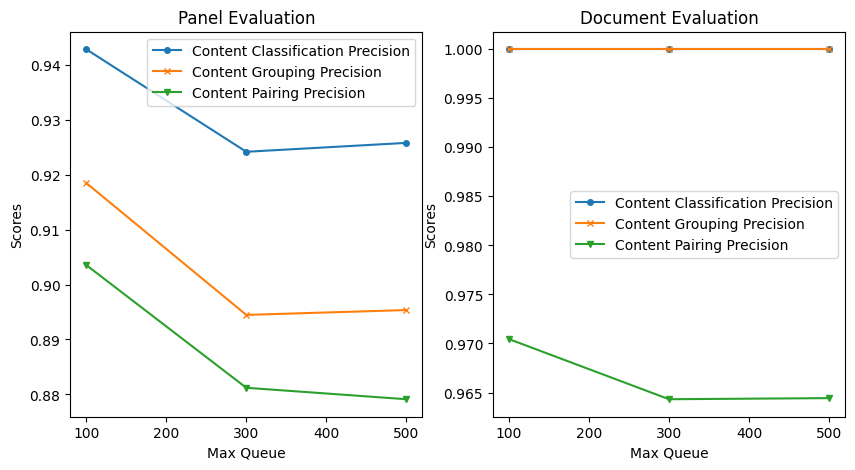

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plot(ax[0], panel_eval.copy(), 'max_queuesize', min_area=0.01, min_keypoints=20, rank_top_k=400)
ax[0].set_xlabel("Max Queue"); ax[0].set_ylabel("Scores"); ax[0].set_title("Panel Evaluation")
plot(ax[1], document_eval.copy(), 'max_queuesize', min_area=0.01, min_keypoints=20, rank_top_k=400)
ax[1].set_xlabel("Max Queue"); ax[1].set_ylabel("Scores"); ax[1].set_title("Document Evaluation")

**Maximum processing queue size**. The processing queue plays a crucial role in the scalability of our method, as it significantly reduces the number of elements that need to be compared. This is essential because, without it, the comparison complexity would be O(n^2), meaning that all elements would need to be compared to each other. However, using a processing queue, we can reduce this to O(n), where only similar elements are compared. Besides that, the processing queue allowed us to process each element in parallel.


The optimal results were obtained with a queue size of 300.

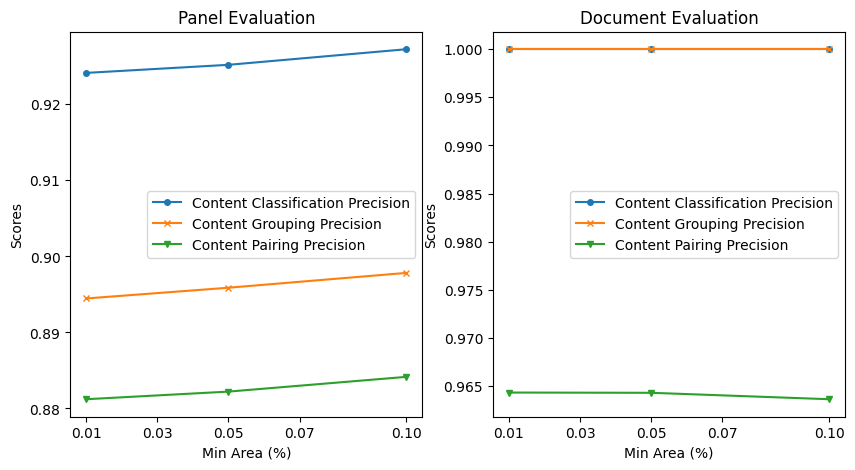

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plot(ax[0], panel_eval.copy(), 'min_area', max_queuesize=300, min_keypoints=20, rank_top_k=400)
ax[0].set_xlabel("Min Area (%)"); ax[0].set_ylabel("Scores"); ax[0].set_title("Panel Evaluation")
ax[0].set_xticks([0.01, 0.03, 0.05, 0.07, 0.1])
plot(ax[1], document_eval.copy(), 'min_area', max_queuesize=300, min_keypoints=20, rank_top_k=400)
ax[1].set_xlabel("Min Area (%)"); ax[1].set_ylabel("Scores"); ax[1].set_title("Document Evaluation")
ax[1].set_xticks([0.01, 0.03, 0.05, 0.07, 0.1])

**Minimum shared Area** defines the minimum shared area that two panels must have to be considered reuse. This parameter ranges from 0 to 1. Setting it to zero means that any retrieved item from the top-k will be considered as a possible reuse, while setting it to 1 implies that only exact matches will be considered.

The results showed that increasing the minimum area for considering a match decreases the performance of the pairing scores (that measures the effectiveness of a method to link reused elements accurately).
This occurs due to the increase in precision but at the cost of losing the correct match (i.e., decreasing the recall). In other words, the method starts to become too conservative to consider a match and starts discarding true positive matches that have a low area of sharing content.

Text(0.5, 1.0, 'Document Evaluation')

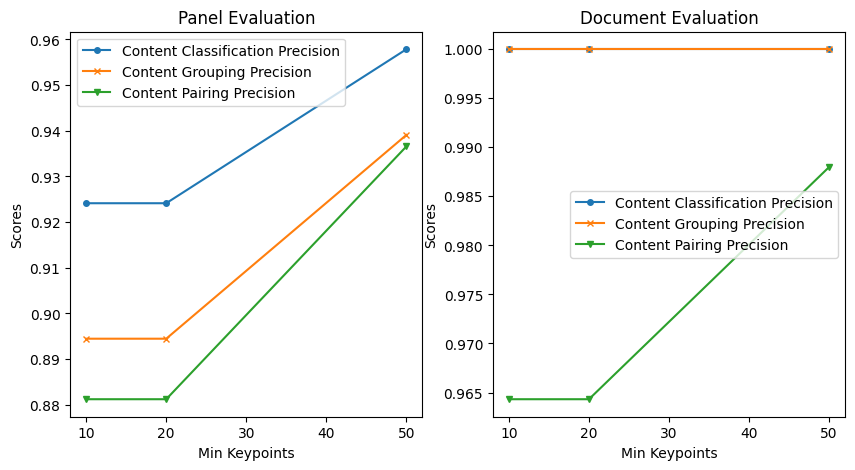

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plot(ax[0], panel_eval.copy(), 'min_keypoints', max_queuesize=300,  min_area=0.01, rank_top_k=400)
ax[0].set_xlabel("Min Keypoints"); ax[0].set_ylabel("Scores"); ax[0].set_title("Panel Evaluation")
plot(ax[1], document_eval.copy(), 'min_keypoints', max_queuesize=300, min_area=0.01, rank_top_k=400)
ax[1].set_xlabel("Min Keypoints"); ax[1].set_ylabel("Scores"); ax[1].set_title("Document Evaluation")


**Minimum keypoints matching**:  determines the number of keypoints found by SIFT that must be geometrically matched during the consistent check and matching stage. 
Similarly, as in the minimum area experiment, when raising the minimum number of keypoints, the method lowers its performance due to the same conservative explanation as before. The high number of keypoints to be considered makes the method prefer to err on the side of caution and prioritize precision over recall in its matching process.

We observed that setting the minimum keypoints to 20 had minimal impact on performance, and we opted to retain this value as it aligns with our intuition that the method may generalize more effectively when applied to other types of data.
